## Pipelines

- No good way to introduce sample weights for GBM with sklearn wrapper
- To add GBMs with resampling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill as pickle
from datetime import datetime
import os
import errno

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.utils import resample
from sklearn.externals import joblib
import sklearn.metrics as metrics

## Read the relevant pieces
- X_train, X_test, y_train, y_test
- Feature transformer functions

In [2]:
X_train = pd.read_pickle("../grab-ai-safety-data/X_train_transformed.pickle")
X_test = pd.read_pickle("../grab-ai-safety-data/X_test.pickle")
y_test = pd.read_pickle("../grab-ai-safety-data/y_test.pickle")
y_train = pd.read_pickle("../grab-ai-safety-data/y_train.pickle")

clean_columns = pickle.load(open("outputs/functions/clean_columns.pickle", "rb"))
create_windows = pickle.load(open("outputs/functions/create_windows.pickle", "rb"))
extract_features = pickle.load(open("outputs/functions/extract_features.pickle", "rb"))
min_boundary = pickle.load(open("outputs/functions/min_boundary.pickle", "rb"))
max_boundary = pickle.load(open("outputs/functions/max_boundary.pickle", "rb"))
min_speed = pickle.load(open("outputs/functions/min_speed.pickle", "rb"))
max_speed = pickle.load(open("outputs/functions/max_speed.pickle", "rb"))
min_accuracy = pickle.load(open("outputs/functions/min_accuracy.pickle", "rb"))
max_accuracy = pickle.load(open("outputs/functions/max_accuracy.pickle", "rb"))

In [3]:
y_train = y_train.drop_duplicates(subset="bookingID", keep="first").set_index("bookingID")
y_test = y_test.drop_duplicates(subset="bookingID", keep="first").set_index("bookingID")

## Apply transformations to test sets

In [4]:
X_test = (
    X_test.pipe(
        clean_columns
    ).pipe(
        create_windows
    ).pipe(
        extract_features
    )
)

In [5]:
y_train = pd.merge(
    X_train, 
    pd.DataFrame(y_train), 
    how="left", 
    left_index=True, 
    right_index=True
)["label"]

In [6]:
y_test = pd.merge(
    X_test,
    pd.DataFrame(y_test),
    how="left",
    left_index=True,
    right_index=True
)["label"]

## Resampling data
- Find a way to take care of class imbalance

In [7]:
'''df_grouped = pd.concat([X_train, y_train], axis=1)
df_majority = df_grouped[df_grouped["label"] == 0]
df_minority = df_grouped[df_grouped["label"] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.count()[0],
    random_state=42
)

df_grouped = pd.concat(
    [df_majority, df_minority_upsampled]
)

X_train = df_grouped.iloc[:, :-1]
y_train = df_grouped.iloc[:, -1]'''

'df_grouped = pd.concat([X_train, y_train], axis=1)\ndf_majority = df_grouped[df_grouped["label"] == 0]\ndf_minority = df_grouped[df_grouped["label"] == 1]\n\ndf_minority_upsampled = resample(\n    df_minority,\n    replace=True,\n    n_samples=df_majority.count()[0],\n    random_state=42\n)\n\ndf_grouped = pd.concat(\n    [df_majority, df_minority_upsampled]\n)\n\nX_train = df_grouped.iloc[:, :-1]\ny_train = df_grouped.iloc[:, -1]'

## Model Pipelines
- Define pipelines
    - GBM
    - Logisitc Regresion
    - Logistic Regression with PCA
    - Random Forests
    - Random Forests with PCA
- Define GS grids
- To add in grid search parameters

In [8]:
jobs = -1

pipe_gbm = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]
)

pipe_lr = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", LogisticRegression(
            random_state=42, 
            penalty="l2", 
            max_iter=4000)
        )
    ]
)

'''pipe_lr_pca = Pipeline(
    [
        ("scl", StandardScaler()),
        ("pca", PCA(n_components=2)),
        ("clf", LogisticRegression( 
            random_state=42, 
            penalty="l2",
            max_iter=4000
        ))
    ]
)'''

pipe_rf = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", RandomForestClassifier(
            random_state=42, 
            class_weight="balanced")
        )
    ]
)

'''pipe_rf_pca = Pipeline(
    [
        ("scl", StandardScaler()),
        ("pca", PCA(n_components=2)),
        ("clf", RandomForestClassifier(
            random_state=42, 
            class_weight="balanced"))
    ]
)'''

'pipe_rf_pca = Pipeline(\n    [\n        ("scl", StandardScaler()),\n        ("pca", PCA(n_components=2)),\n        ("clf", RandomForestClassifier(\n            random_state=42, \n            class_weight="balanced"))\n    ]\n)'

In [9]:
grid_params_gbm = [
    {
        "clf__learning_rate": [0.05, 0.1],
        #"clf__min_samples_split": np.linspace(0.1, 0.5, 2),
        #"clf__min_samples_leaf": np.linspace(0.1, 0.5, 2),
        "clf__max_depth":[3, 5, 8],
        "clf__max_features":["log2"],
        "clf__n_estimators":[50, 100]
    }
]

grid_params_lr = [
   {
        "clf__solver" : ["lbfgs", "saga"],
        "clf__C" : [0.1, 0.5, 1],
   }
]

grid_params_rf = [
    { 
        "clf__n_estimators" : [50, 100],
        "clf__max_features" : [0.5, 0.75],
        "clf__max_depth" : [3, 5, 8]
    }
]


In [10]:
gs_gbm = GridSearchCV(
    estimator=pipe_gbm,
    param_grid=grid_params_gbm,
    scoring="roc_auc",
    cv=10,
    n_jobs=jobs
)

gs_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=grid_params_lr,
    scoring="roc_auc",
    cv=10
) 

'''gs_lr_pca = GridSearchCV(
    estimator=pipe_lr_pca,
    param_grid=grid_params_lr,
    scoring="roc_auc",
    cv=10
)'''

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=grid_params_rf,
    scoring="roc_auc",
    cv=10, 
    n_jobs=jobs
)

'''gs_rf_pca = GridSearchCV(
    estimator=pipe_rf_pca,
    param_grid=grid_params_rf,
    scoring="roc_auc",
    cv=10, 
    n_jobs=jobs
)'''

'gs_rf_pca = GridSearchCV(\n    estimator=pipe_rf_pca,\n    param_grid=grid_params_rf,\n    scoring="roc_auc",\n    cv=10, \n    n_jobs=jobs\n)'

In [11]:
grids = [
    gs_gbm, 
    gs_lr, 
    # gs_lr_pca, 
    gs_rf, 
    # gs_rf_pca
]

grid_dict = {
    0: "Gradient Boosted Machine",
    1: "Logistic Regression", 
    # 2: "Logistic Regression w/PCA", 
    2: "Random Forest", 
    # 4: "Random Forest w/PCA", 
}

# Fit the grid search objects
print("Performing model optimizations...")
best_acc = 0.0
best_clf = 0
best_gs = ''
time_stamp = []
for idx, gs in enumerate(grids):
    print("\nEstimator: %s" % grid_dict[idx])

    gs.fit(X_train, y_train)

    print("Best params: %s" % gs.best_params_)
    print("Best training accuracy: %.3f" % gs.best_score_)

    y_pred = gs.predict(X_test)
    y_prob = gs.predict_proba(X_test)[:, 1]

    print("Test set accuracy score for best params: %.3f " % accuracy_score(y_test, y_pred))
    print("ROC_AUC score for best params: %.3f" % roc_auc_score(y_test, y_prob))

    if roc_auc_score(y_test, y_prob) > best_acc:
        best_acc = roc_auc_score(y_test, y_prob)
        best_gs = gs
        best_clf = idx
        time_stamp = str(datetime.now(tz=None).microsecond)
print("\nClassifier with best test set accuracy: {}".format(grid_dict[best_clf]))

# Dumps the corresponding best model and functions into a specific folder

model_destination = "./outputs/models" + "/" + time_stamp
if not os.path.exists(model_destination):
    try:
        os.makedirs(model_destination)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise

joblib.dump(
    gs, "./outputs/models/" + time_stamp + "/" + grid_dict[best_clf] + 
    "_" + str(np.round(best_acc, 2)) + ".pkl"
) 

with open("outputs/models/" + time_stamp + "/" + "clean_columns.pickle", "wb") as handle:
    pickle.dump(clean_columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "create_windows.pickle", "wb") as handle:
    pickle.dump(create_windows, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "extract_features.pickle", "wb") as handle:
    pickle.dump(extract_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "min_boundary.pickle", "wb") as handle:
    pickle.dump(min_boundary, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "max_boundary.pickle", "wb") as handle:
    pickle.dump(max_boundary, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "min_accuracy.pickle", "wb") as handle:
    pickle.dump(min_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "max_accuracy.pickle", "wb") as handle:
    pickle.dump(max_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "min_speed.pickle", "wb") as handle:
    pickle.dump(min_speed, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("outputs/models/" + time_stamp + "/" + "max_speed.pickle", "wb") as handle:
    pickle.dump(max_speed, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(
    "{} and associated functions have been successfully exported".format(grid_dict[best_clf])
)

Performing model optimizations...

Estimator: Gradient Boosted Machine
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__n_estimators': 100}
Best training accuracy: 0.729
Test set accuracy score for best params: 0.776 
ROC_AUC score for best params: 0.735

Estimator: Logistic Regression
Best params: {'clf__C': 1, 'clf__solver': 'saga'}
Best training accuracy: 0.717
Test set accuracy score for best params: 0.775 
ROC_AUC score for best params: 0.723

Estimator: Random Forest
Best params: {'clf__max_depth': 8, 'clf__max_features': 0.75, 'clf__n_estimators': 100}
Best training accuracy: 0.727
Test set accuracy score for best params: 0.696 
ROC_AUC score for best params: 0.733

Classifier with best test set accuracy: Gradient Boosted Machine
Gradient Boosted Machine and associated functions have been successfully exported


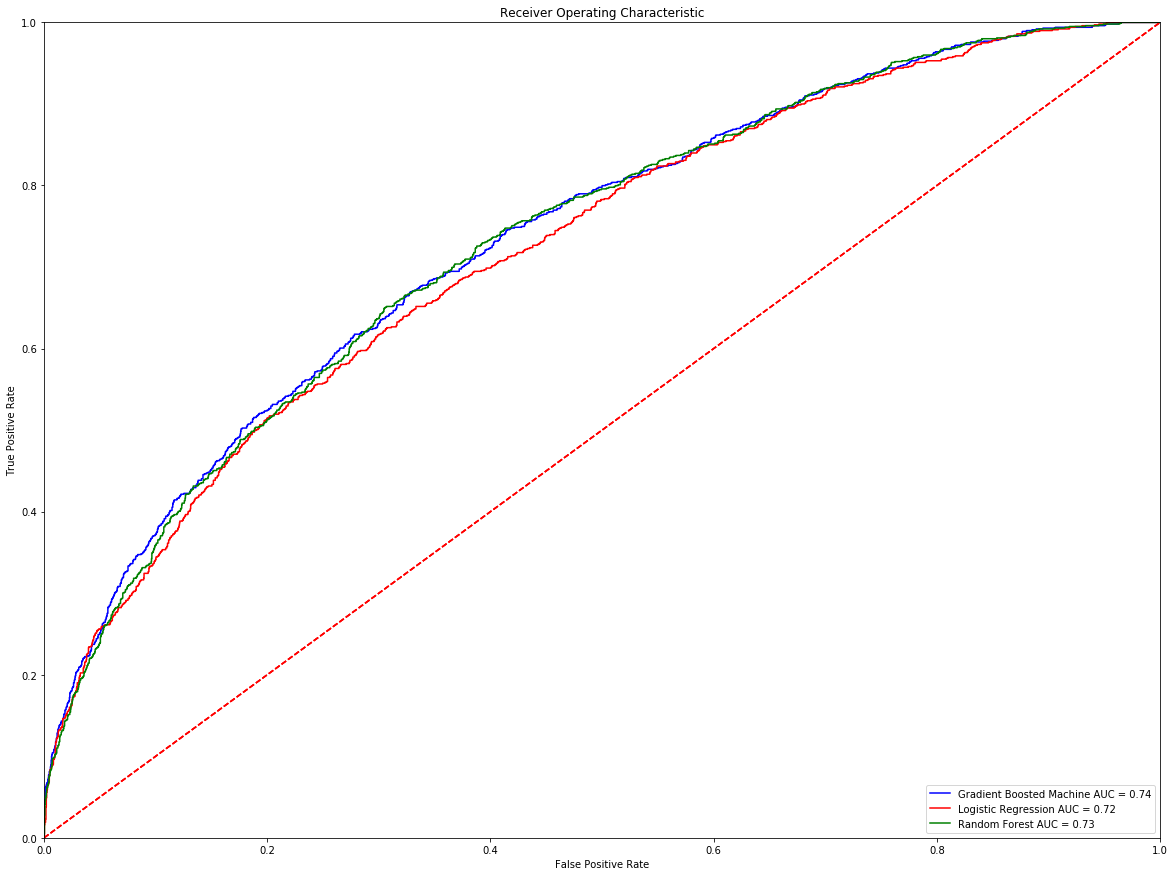

In [12]:
color_dict = {
    0: "blue",
    1: "red", 
    2: "green", 
    3: "black", 
    4: "purple", 
}
plt.figure(figsize=(20, 15))
for idx, gs in enumerate(grids):
    probs = gs.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title("Receiver Operating Characteristic")
    plt.plot(
        fpr, 
        tpr, 
        color=color_dict[idx], 
        label = "%s AUC = %0.2f" % (grid_dict[idx], roc_auc)
    )
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
plt.show()

## Plot feature importances

In [13]:
rf = RandomForestClassifier(
    random_state=42, 
    class_weight="balanced"
).fit(X_train, y_train)

feature_importances = pd.DataFrame(
    rf.feature_importances_,
    index = X_train.columns,
    columns=["importance"]
).sort_values(
    "importance", 
    ascending=False
)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<BarContainer object of 13 artists>

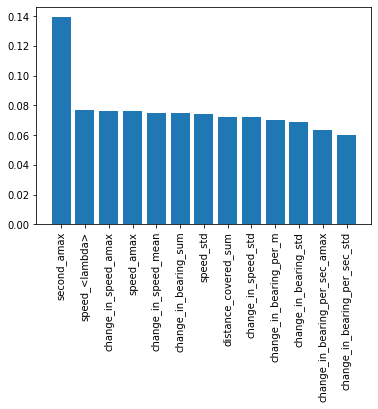

In [14]:
plt.xticks(rotation=90)
plt.bar(feature_importances.index, feature_importances["importance"])

## Cross validation
- Check if there is data leakage?
- A sudden jump to 90% accuracy seems dubious

In [15]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cross_val_score(
    pipe_rf, 
    X_train, 
    y_train, 
    cv=cv
)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

array([0.76441103, 0.76221805, 0.77349624, 0.76378446, 0.77412281,
       0.77005013, 0.76879699, 0.77255639, 0.76347118, 0.76002506])